In [269]:
conda install -c conda-forge catboost

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [270]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [271]:
import numpy as np
import pandas as pd
import random

import sklearn as skl
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from catboost import CatBoostRegressor
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [272]:
import warnings
warnings.filterwarnings('ignore')

In [273]:
matplotlib.rcParams.update({'font.size' : 14})

In [274]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values) :
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18, 10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    
    plt.show()

In [275]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

In [276]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [277]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [278]:
# Division of the features on texts and figures
num_feat = list(train_df.select_dtypes(exclude='object').columns)
obj_feat = list(train_df.select_dtypes(include='object').columns)
target = 'Price'

num_feat

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price']

In [279]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [280]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте:', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте: 5000


In [281]:
train_df.shape[1] - 1 == test_df.shape[1]

True

In [282]:
submission_df = pd.read_csv('./sample_submission.csv')

In [283]:
train_df['Id'] = train_df['Id'].astype(str)

In [284]:
train_df.dtypes

Id                object
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [285]:
train_df.dtypes.value_counts()

int64      8
float64    8
object     4
dtype: int64

In [286]:
train_df['Id'] = train_df['Id'].astype(str)

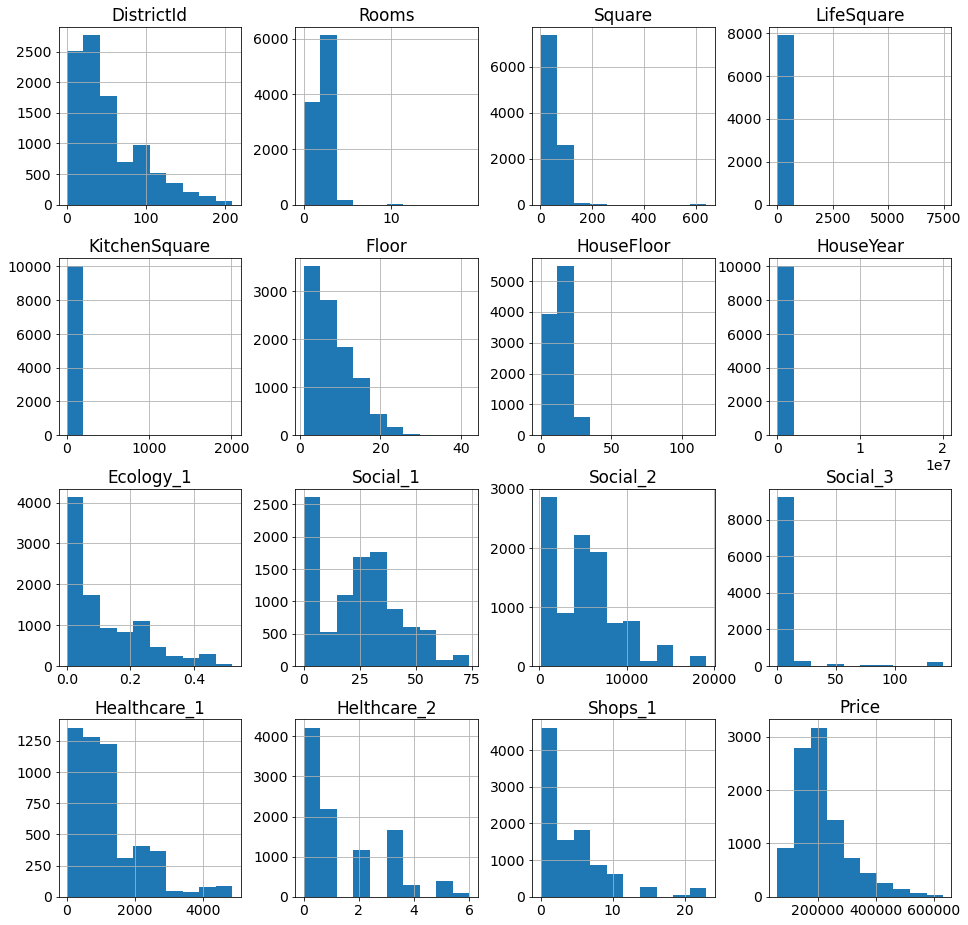

In [287]:
# Features Search avec data outliers
train_df[num_feat].hist(
    figsize=(16,16)
)
plt.show()

In [288]:
# Data outliers are in HouseYear, KitchenSquare. There are some anomalies to be removed: HouseFloor, LifeSquare, Rooms, Square 

In [289]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01


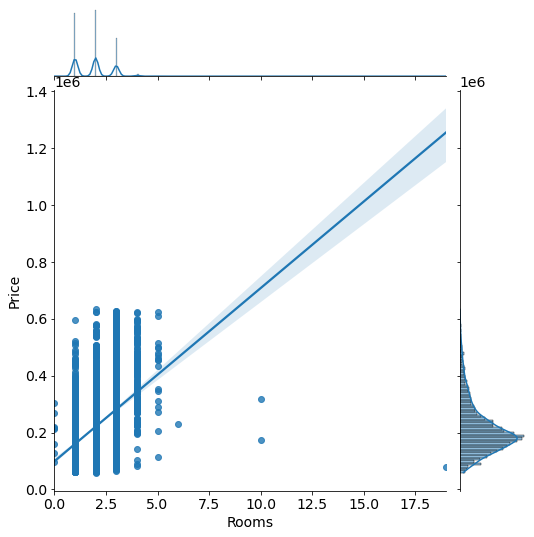

In [290]:
grid = sns.jointplot(train_df['Rooms'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

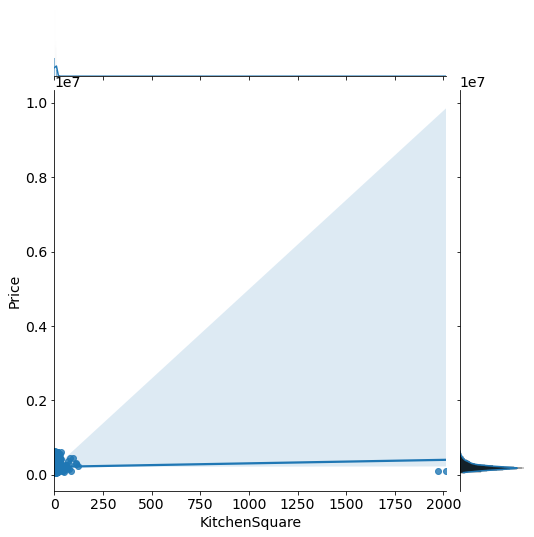

In [291]:
grid = sns.jointplot(train_df['KitchenSquare'], train_df['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

In [292]:
# Build up the range between 1 and 250

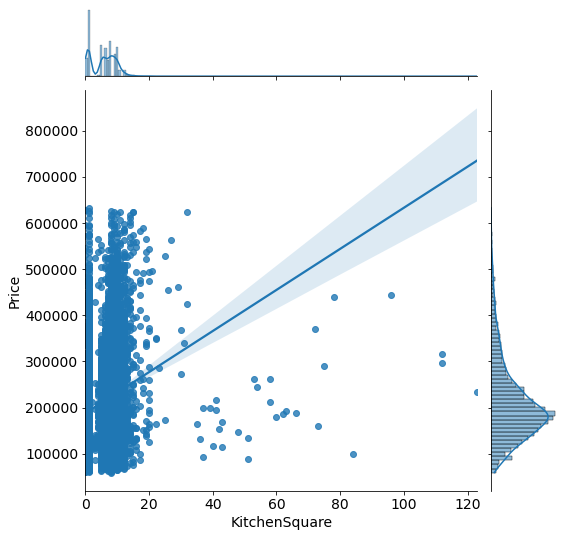

In [293]:
train_df_temp = train_df.loc[train_df['KitchenSquare']<250]
grid = sns.jointplot(train_df_temp['KitchenSquare'], train_df_temp['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

In [294]:
# 30 sq m < Data outlier < 3 sq m 

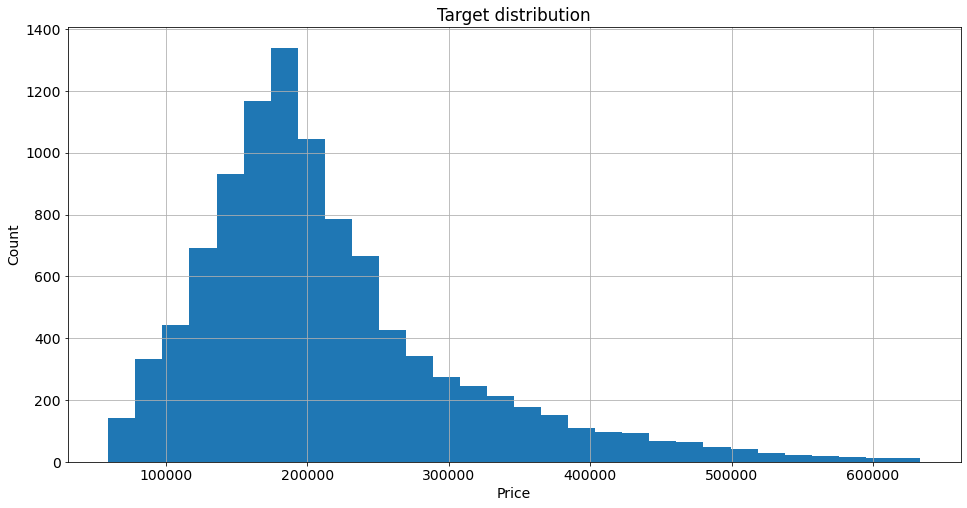

In [295]:
# Target feature distribution and correlations

plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

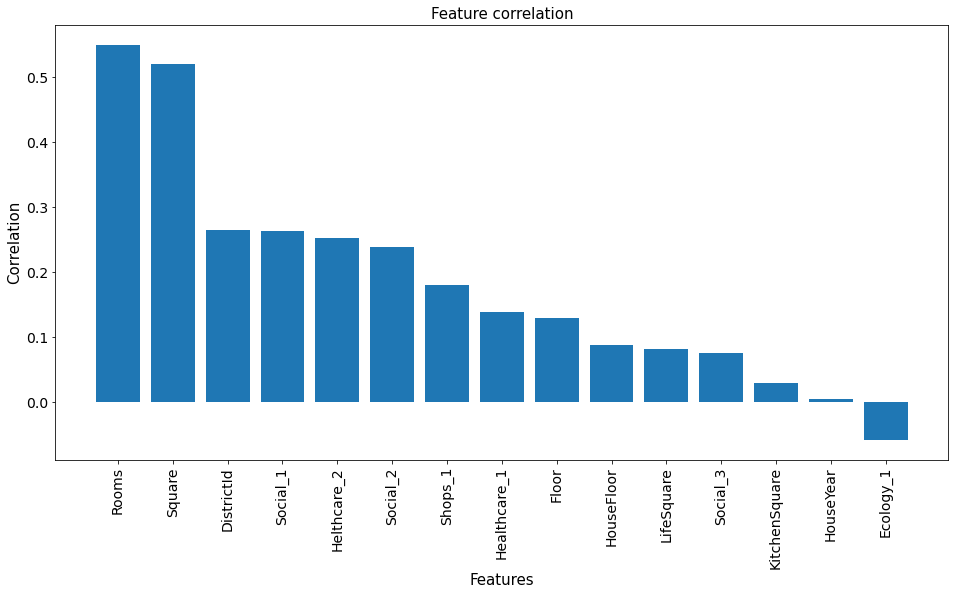

In [296]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (16, 8))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

In [297]:
# train_df.select_dtypes(include='object').columns.tolist()

In [298]:
# train_df['DistrictId'].value_counts()

In [299]:
# train_df[Ecology_2].value_counts()

In [300]:
# train_df['Shops_2'].value_counts()

In [301]:
# Categorial variable
# cat_colnames = train_df.select_dtypes(include='object').columns.tolist()
# cat_colnames

In [302]:
# for cat_colname in cat_colnames[2:]:
    # print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

In [303]:
# Rooms
# train_df['Rooms'].value_counts()

In [304]:
# train_df['Rooms_outlier'] = 0
# train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
# train_df.head()

In [305]:
# train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
# train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [306]:
# train_df['Rooms'].value_counts()

In [307]:
# KitchenSquare
# train_df['KitchenSquare'].value_counts()

In [308]:
# train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

In [309]:
# condition = (train_df['KitchenSquare'].isna()) | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))

# train_df.loc[condition, 'KitchenSquare'] = train_df['KitchenSquare'].median()

# train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [310]:
# train_df['KitchenSquare'].value_counts()

In [311]:
# HouseFloor, Floor
# train_df['HouseFloor'].sort_values().unique()

In [312]:
# train_df['Floor'].sort_values().unique()

In [313]:
# (train_df['Floor'] > train_df['HouseFloor']).sum()

In [314]:
# train_df['HouseFloor_outlier'] = 0
# train_df.loc[train_df['HouseFloor'] = 0, 'HouseFloor_outlier'] = 1
# trai_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [315]:
# train_df.loc[train_df['HouseFloor'] = 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [316]:
# floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
# floor_outliers

In [317]:
# train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
# .apply(lambda x: random.randint(1, x))

In [318]:
# (train_df['Floor'] > train_df['HouseFloor']).sum()

In [319]:
# HouseYear
# train_df['HouseYear'].sort_values(ascending=False)

In [320]:
# train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

In [321]:
# Passes processing
# train_df.isna().sum()

In [322]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,1.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,1.0
9,79.867477,75.085125,1.0


In [323]:
# LifeSquare
# train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

# condition = (train_df['LifeSquare'].isna()) \
# & (~train_df['Square'].isna()) \
# & (~train_df['KitchenSquare'].isna())

# train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \

# - train_df.loc[condition, 'KitchenSquare'] - 3

In [324]:
# Healthcare_1
# train_df.drop('Healthcare_1', axis=1, inplace=True)

In [325]:
class DataPreprocessing:
    # Preparation of data
    def __init__(self):
        # Class parameters
        # self.medians = None
        # self.kitchen_square_max_value = None
        # self.kitchen_square_min_value = None
        # self.life_square_min_value = None
        # self.max_floor = None
        # self.districts_healthcare = None
        self.Square_min = 15
        self.Square_max = 300
        self.LifeSquare_min = 10
        self.LifeSquare_max = 280
        self.Rooms_min = 1
        self.Rooms_max = 5
        self.HouseFloor_min = 1
        self.HouseFloor_max = 50
        self.KitchenSquare_min = 3
        self.KitchenSquare_max = 30
        self.current_year = datetime.now().year
        self.medians = None
        self.DistrictId_value_counts = None
        self.SquareMeterPrice_by_DistrictId = None
        self.Healthcare_1_by_DistrictId = None
    
    # def fit(self, df):
        # Medians and quantiles
        # self.medians = df.median() # medians
        # self.kitchen_square_max_value = np.quantile(df['KitchenSquare'], q=0.999) 
        # self.kitchen_square_min_value = np.quantile(df['KitchenSquare'], q=0.001) 
        # self.life_square_min_value = np.quantile(df['LifeSquare'], q=0.03) 
        # self.max_floor = df['Floor'].max()
        
    def fit(self, train_df):
        # medians
        self.medians = train_df[['LifeSquare', 'HouseFloor']].median()
        # popular districts
        self.DistrictId_value_counts = dict(train_df['DistrictId'].value_counts())
        # average price for 2 sq m in the district
        train_df_temp = train_df.loc[((train_df['Square'] > self.Square_min) & (train_df['Square'] < self.Square_max))]
        train_df_temp["SquareMeterPrice"] = train_df_temp["Price"] / train_df_temp["Square"]
        self.SquareMeterPrice_by_DistrictId = train_df_temp.groupby('DistrictId', as_index=False)\
            .agg({'SquareMeterPrice': 'mean'})\
            .rename(columns={'SquareMeterPrice': 'AverageSquareMeterPrice'})
        # average value of Healthcare_1 in the district
        self.Healthcare_1_by_DistrictId = train_df.groupby('DistrictId', as_index=False)\
            .agg({'Healthcare_1': 'mean'})\
            .rename(columns={'Healthcare_1': 'AverageHealthcare_1'})
        
        del train_df_temp
        
    def transform(self, train_df):
        # Passes processing
        train_df[['LifeSquare', 'HouseFloor']] = train_df[['LifeSquare', 'HouseFloor']].fillna(self.medians)
        # Outliers processing
        # Square
        train_df.loc[(train_df['Square'] > self.Square_max), 'Square'] = self.Square_max
        train_df.loc[(train_df['Square'] < self.Square_min), 'Square'] = self.Square_min
        # LifeSquare
        train_df.loc[(train_df['LifeSquare'] < self.LifeSquare_min), 'LifeSquare'] = self.LifeSquare_min
        train_df.loc[(train_df['LifeSquare'] > self.LifeSquare_max), 'LifeSquare'] = self.LifeSquare_max
        # KitchenSquare
        train_df.loc[(train_df['KitchenSquare'] < self.KitchenSquare_min), 'KitchenSquare'] = self.KitchenSquare_min
        train_df.loc[(train_df['KitchenSquare'] > self.KitchenSquare_max), 'KitchenSquare'] = self.KitchenSquare_max
        
        # HouseYear
        # If HouseYear > current year set median value
        #current_year = datetime.now().year
        #condition_year = (df['HouseYear'] > current_year)
        #df.loc[condition_year, 'HouseYear'] = self.medians.HouseYear
        train_df.loc[(train_df['HouseYear'] > self.current_year), 'HouseYear'] = self.current_year
        
        # Rooms
        train_df.loc[(train_df['Rooms'] > self.Rooms_max), 'Rooms'] = self.Rooms_max
        train_df.loc[(train_df['Rooms'] < self.Rooms_min), 'Rooms'] = self.Rooms_min
        # Floors
        train_df.loc[(train_df['HouseFloor'] < self.HouseFloor_min), 'HouseFloor'] = self.HouseFloor_min
        train_df.loc[(train_df['HouseFloor'] > self.HouseFloor_max), 'HouseFloor'] = self.HouseFloor_max
        
        # If HouseFloor < Floor: exchange values
        # house_floor_condition = df['HouseFloor'] < df['Floor']
        # df.loc[house_floor_condition, 'HouseFloor'] = df.loc[house_floor_condition, 'Floor']
        floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
        train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: self.HouseFloor_min if (self.HouseFloor_min == x) else np.random.randint(self.HouseFloor_min, x))
        
        #Categories processing 
        train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_2'], prefix='Ecology_2', dtype='int8')], axis=1)
        train_df = pd.concat([train_df, pd.get_dummies(train_df['Ecology_3'], prefix='Ecology_3', dtype='int8')], axis=1)
        train_df = pd.concat([train_df, pd.get_dummies(train_df['Shops_2'], prefix='Shops_2', dtype='int8')], axis=1)
        
        return train_df
    
    def features(self, train_df):
        # popularity features adding
        train_df['DistrictId_counts'] = train_df['DistrictId'].map(self.DistrictId_value_counts)
        train_df['DistrictId_counts'].fillna(train_df['DistrictId_counts'].median(), inplace=True)
        # average price for sq meter in the district feature adding
        train_df = train_df.merge(self.SquareMeterPrice_by_DistrictId, on=["DistrictId"], how='left')
        train_df['AverageSquareMeterPrice'].fillna(train_df['AverageSquareMeterPrice'].median(), inplace=True)
        # average value of Healthcare_1 feature adding
        train_df = train_df.merge(self.Healthcare_1_by_DistrictId, on=["DistrictId"], how='left')
        train_df['AverageHealthcare_1'].fillna(train_df['AverageHealthcare_1'].median(), inplace=True)
        
        return train_df

In [326]:
# Data Initialization
data_inst = DataPreprocessing()
# Train Data
data_inst.fit(train_df)
train_df = data_inst.transform(train_df)
train_df = data_inst.features(train_df)
# Test Data
test_df = data_inst.transform(test_df)
test_df = data_inst.features(test_df)

In [327]:
# The list of features for the model
feature_names = ['AverageSquareMeterPrice', 'DistrictId_counts', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
                    'HouseFloor', 'HouseYear', 'Helthcare_2', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                    'Shops_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B',
                    'AverageHealthcare_1']
target_name = 'Price'

In [328]:
train_df = train_df[feature_names + [target_name]]
test_df = test_df[feature_names + ['Id']]
X = train_df[feature_names]
y = train_df[target_name]

In [329]:
# CatBoostRegressor 
final_model = CatBoostRegressor(
    silent=True,
    learning_rate=0.1,
    iterations=1150,
    eval_metric='R2',
    depth=8
)

final_model.fit(X, y)

cv_score = cross_val_score(
    final_model,
    X,
    y,
    scoring='r2',
    cv=KFold(
            n_splits=5,
            shuffle=True,
            random_state=42
    )
)

In [330]:
print(f'R2: {round(cv_score.mean(), 3)}')

R2: 0.755


In [331]:
# Gradient Boosting Regressor model fit and predict for train dataset
# gb_model = GradientBoostingRegressor(criterion='mse',
                                     # max_depth=6,
                                     # min_samples_leaf=50,
                                     # random_state=42,  
                                     # n_estimators=2250, 
                                     # max_features='sqrt', 
                                     # loss='huber', 
                                     # learning_rate=0.025)

# gb_model.fit(X_train, y_train)

# y_train_preds = gb_model.predict(X_train)
# y_test_preds = gb_model.predict(X_test)
# print(r2(y_train, y_train_preds))
# print(r2(y_test, y_test_preds))

In [332]:
# Features Sorting
feature_importances = pd.DataFrame(
    zip(X.columns, final_model.get_feature_importance()),
    columns=['feature_name', 'importance']
)

feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances.head(20)

,feature_name,importance
3,Square,28.038214
0,AverageSquareMeterPrice,18.413155
8,HouseYear,8.127086
5,KitchenSquare,5.523145
4,LifeSquare,4.735959
7,HouseFloor,4.312863
10,Ecology_1,4.235764
6,Floor,4.007856
1,DistrictId_counts,3.893005
12,Social_2,3.685121


In [333]:
# class DataPreprocessing:
    # Preparation of data
    # def __init__(self):
        # Class parameters
        # self.medians = None
        # self.kitchen_square_quantile = None
        
    # def fit(self, X):
        # Statistics saving
        # self.medians = X.median()
        # self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        
    # def transform(self, X):
        # Data transformation
        # Rooms
        # X['Rooms_putlier'] = 0
        # X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        # X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        # X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        # condition = (X['KitchenSquare'].isna()) \
        
        # | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        # X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        # X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        # X['HouseFloor_outlier'] = 0
        # X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        # X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        # X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        # floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        # X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
        
        # .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        # current_year = datetime.now().year
        
        # X['HouseYear_outlier'] = 0
        # X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        # X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        # if 'Healthcare_1' in X.columns:
            # X.drop('Healthcare_1', axis=1, inplace=True)
            
        #LifeSquare
        # X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        # condition = (X['LifeSquare'].isna()) & \
        # (~X['Square'].isna()) & \
        # (~X['KitchenSquare'].isna())
        
        # X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        # X.fillna(self.medians, inplace=True)
        
        # return X
        

In [334]:
# Dummies
# binary_to_numbers = {'A' : 0, 'B' : 1}

# train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
# train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
# train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

In [335]:
# DistrictSize, IsDistrictLarge
# district_size = train_df['DistrictId'].value_counts().reset_index()\
                    # .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

# district_size.head()

In [336]:
# train_df = train_df.merge(district_size, on='DistrictId', how='left')
# train_df.head()

In [337]:
# (train_df['DistrictSize'] > 100).value_counts()

In [338]:
# train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [339]:
# MedPriceByDistrict
# med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            # .rename(columns={'Price':'MedPriceByDistrict'})

# med_price_by_district.head()

In [340]:
# med_price_by_district.shape

In [341]:
# train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
# train_df.head()

In [342]:
# MedPriceByFloorYear
# def floor_to_cat(X):

    # X['floor_cat'] = 0

    # X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    # X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    # X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    # X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    # X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    # return X


# def floor_to_cat_pandas(X):
    # bins = [X['Floor'].min(), 3, 5, 9, 15, X['Floor'].max()]
    # X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    # X['floor_cat'].fillna(-1, inplace=True)
    # return X


# def year_to_cat(X):

    # X['year_cat'] = 0

    # X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    # X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    # X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    # X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    # X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    # X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    # return X


# def year_to_cat_pandas(X):
    # bins = [X['HouseYear'].min(), 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    # X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    # X['year_cat'].fillna(-1, inplace=True)
    # return X

In [343]:
# bins = [train_df['Floor'].min(), 3, 5, 9, 15, train_df['Floor'].max()]
# pd.cut(train_df['Floor'], bins=bins, labels=False)

In [344]:
# bins = [train_df['Floor'].min(), 3, 5, 9, 15, train_df['Floor'].max()]
# pd.cut(train_df['Floor'], bins=bins)

In [345]:
# train_df = year_to_cat(train_df)
# train_df = floor_to_cat(train_df)
# train_df.head()

In [347]:
# med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            # rename(columns={'Price':'MedPriceByFloorYear'})
# med_price_by_floor_year.head()

In [348]:
# train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
# train_df.head()

In [349]:
# class FeatureGenetator():
    # """Генерация новых фич"""
    
    # def __init__(self):
        # self.DistrictId_counts = None
        # self.binary_to_numbers = None
        # self.med_price_by_district = None
        # self.med_price_by_floor_year = None
        # self.house_year_max = None
        # self.floor_max = None
        # self.house_year_min = None
        # self.floor_min = None
        # self.district_size = None
        
    # def fit(self, X, y=None):
        
        # X = X.copy()
        
        # Binary features
        # self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        # self.district_size = X['DistrictId'].value_counts().reset_index() \
                               # .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        # df = X.copy()
        
        # if y is not None:
            # df['Price'] = y.values
            
            # self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            # .rename(columns={'Price':'MedPriceByDistrict'})
            
            # self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        # if y is not None:
            # self.floor_max = df['Floor'].max()
            # self.floor_min = df['Floor'].min()
            # self.house_year_max = df['HouseYear'].max()
            # self.house_year_min = df['HouseYear'].min()
            # df['Price'] = y.values
            # # df = self.floor_to_cat(df)
            # df = self.year_to_cat(df)
            # self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            # rename(columns={'Price':'MedPriceByFloorYear'})
            # self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    # def transform(self, X):
        
        # Binary features
        # X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        # X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        # X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        # X = X.merge(self.district_size, on='DistrictId', how='left')
        
        # X['new_district'] = 0
        # X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        # X['DistrictSize'].fillna(5, inplace=True)
        
        # X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        # X = self.floor_to_cat(X)  # + столбец floor_cat
        # X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        # if self.med_price_by_district is not None:
            # X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            # X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        # if self.med_price_by_floor_year is not None:
            # X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            # X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        # return X
    
    # def floor_to_cat(self, X):
        # bins = [self.floor_min, 3, 5, 9, 15, self.floor_max]
        # X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        # X['floor_cat'].fillna(-1, inplace=True)
        # return X
     
    # def year_to_cat(self, X):
        # bins = [self.house_year_min, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        # X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        # X['year_cat'].fillna(-1, inplace=True)
        # return X

In [350]:
# Feature Selection
# train_df.columns.tolist()

In [351]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

In [352]:
# Train and Test Selection
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [353]:
# Forecasr on testing
test_df.shape

(5000, 19)

In [354]:
test_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B


In [355]:
preds_final = pd.DataFrame()
preds_final['Id'] = test_df['Id'].copy()

test_df.set_index('Id', inplace=True)
test_df = test_df[feature_names]

In [356]:
y_pred_final = final_model.predict(test_df)

submission_df['Price'] = y_pred_final
submission_df.to_csv('./sample_submission.csv', index=False, encoding='utf-8', sep=',')

submission_df.head()

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=8]="B": Cannot convert 'b'B'' to float